In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

<module 'libs.models' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch.nn as nn
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['bid','ask'] + [params.label_col]]
    
df_feat_sel

,vwap_dev_15,vol_15,rsi_15,bb_width_15,r_30,r_15,bb_hband_15,sma_30,bb_lband_15,sma_15,ema_7,stoch_d_3,stoch_k_15,bid,ask,signal
2004-01-02 13:09:00,-0.040178,-1.470597,-2.557298,-1.574415,-0.018856,-0.025470,-0.594094,-1.165607,-0.593601,-1.165606,-1.165607,-1.876805,-1.785354,0.763664,0.764807,0.021536
2004-01-02 13:10:00,-0.048980,-1.466297,-2.557298,-1.545814,-0.024582,-0.033444,-0.594093,-1.165607,-0.593602,-1.165607,-1.165608,-1.876805,-1.785354,0.763647,0.764790,0.023284
2004-01-02 13:11:00,-0.056140,-1.463327,-2.557298,-1.516045,-0.030308,-0.041417,-0.594093,-1.165607,-0.593603,-1.165607,-1.165609,-1.876805,-1.785354,0.763631,0.764773,0.025175
2004-01-02 13:12:00,-0.061878,-1.461447,-2.557298,-1.485916,-0.036035,-0.049391,-0.594093,-1.165607,-0.593604,-1.165608,-1.165610,-1.876805,-1.785354,0.763614,0.764757,0.027222
2004-01-02 13:13:00,-0.066452,-1.460532,-2.557298,-1.456142,-0.041762,-0.057365,-0.594092,-1.165608,-0.593605,-1.165608,-1.165611,-1.876805,-1.785354,0.763597,0.764740,0.029436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,1.066747,0.884708,0.726751,0.844220,1.054542,1.323284,8.036307,12.644104,8.016463,12.657129,12.671316,0.445263,0.700633,196.667400,196.962600,0.684908
2025-06-18 20:57:00,0.436767,0.942109,0.484027,0.825992,1.142149,1.119932,8.037852,12.646131,8.018473,12.659979,12.673227,0.508794,0.361998,196.527500,196.822500,0.612206
2025-06-18 20:58:00,0.331541,0.919047,0.475468,0.848628,1.381234,0.832284,8.039467,12.648581,8.019501,12.662099,12.674571,0.471436,0.340989,196.522500,196.817500,0.610468
2025-06-18 20:59:00,-1.002846,1.231640,-0.145922,0.866409,0.797727,-0.094278,8.039552,12.649994,8.019122,12.661864,12.667983,-0.037350,-0.857130,196.092800,196.387200,0.477090


In [4]:
# Build LSTM input tensors (disk-backed memmaps)
X, y_sig, y_ret, raw_close, raw_bid, raw_ask, end_times = models.build_lstm_tensors(
    df            = df_feat_sel,
    sess_start    = params.sess_start_pred_tick 
)

# quick shapes
print("Shapes:")
print("  X         =", X.shape,    "(samples, look_back, features)")
print("  y_sig     =", y_sig.shape, "(samples,)")
print("  y_ret     =", y_ret.shape, "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)
print("  end_times =", end_times.shape)


Inside build_lstm_tensors, using: ['vwap_dev_15', 'vol_15', 'rsi_15', 'bb_width_15', 'r_30', 'r_15', 'bb_hband_15', 'sma_30', 'bb_lband_15', 'sma_15', 'ema_7', 'stoch_d_3', 'stoch_k_15']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Shapes:
  X         = torch.Size([2419779, 60, 13]) (samples, look_back, features)
  y_sig     = torch.Size([2419779]) (samples,)
  y_ret     = torch.Size([2419779]) (samples,)
  raw_close = torch.Size([2419779])
  raw_bid   = torch.Size([2419779])
  raw_ask   = torch.Size([2419779])
  end_times = (2419779,)


In [5]:
# Split into train/val/test by calendar day
(
(X_tr,  y_sig_tr,  y_ret_tr),
(X_val, y_sig_val, y_ret_val),
(X_te,  y_sig_te,  y_ret_te,  raw_close_te, raw_bid_te, raw_ask_te),
samples_per_day,
day_id_tr, day_id_val, day_id_te
) = models.chronological_split(
    X, y_sig, y_ret,
    raw_close, raw_bid, raw_ask,
    end_times   = end_times,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.hparams['TRAIN_BATCH']
)

# Print shapes of all tensors
print("Shapes:")
print("  X_tr  =", X_tr.shape)
print("  y_sig_tr, y_ret_tr =", y_sig_tr.shape, y_ret_tr.shape)
print("  X_val =", X_val.shape)
print("  y_sig_val, y_ret_val =", y_sig_val.shape, y_ret_val.shape)
print("  X_te  =", X_te.shape)
print("  y_sig_te, y_ret_te =", y_sig_te.shape, y_ret_te.shape)


Shapes:
  X_tr  = torch.Size([1716386, 60, 13])
  y_sig_tr, y_ret_tr = torch.Size([1716386]) torch.Size([1716386])
  X_val = torch.Size([338701, 60, 13])
  y_sig_val, y_ret_val = torch.Size([338701]) torch.Size([338701])
  X_te  = torch.Size([364692, 60, 13])
  y_sig_te, y_ret_te = torch.Size([364692]) torch.Size([364692])


In [6]:
# carve `end_times` into the same three splits:
n_tr  = day_id_tr .shape[0] 
n_val = day_id_val.shape[0]
i_tr  = n_tr
i_val = n_tr + n_val

end_times_tr  = end_times[:i_tr]
end_times_val = end_times[i_tr:i_val]
end_times_te  = end_times[i_val:]

# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # train split:   
    X_tr,            y_sig_tr,     y_ret_tr,   end_times_tr,
    # val split:
    X_val,           y_sig_val,    y_ret_val,  end_times_val,
    # test split + raw‐prices
    X_te,            y_sig_te,     y_ret_te,   end_times_te,
    raw_close_te, raw_bid_te, raw_ask_te,
    
    sess_start_time       = params.sess_start_pred_tick,
    signal_thresh         = params.best_optuna_params["buy_threshold"],
    return_thresh         = 0.01,  # flat‐zone threshold for returns (to tune)
    train_batch           = params.hparams["TRAIN_BATCH"],
    train_workers         = params.hparams["NUM_WORKERS"],
    train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
)

print(f"Days  → train={len(train_loader.dataset)}, val={len(val_loader.dataset)}, test={len(test_loader.dataset)}")
print(f"Batches → train={len(train_loader)},   val={len(val_loader)},   test={len(test_loader)}")

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Days  → train=3840, val=751, test=809
Batches → train=60,   val=751,   test=809


In [7]:
# -----------------------------------------------------------------------------
# Instantiate the stateful DualMemoryLSTM & move to device
# -----------------------------------------------------------------------------
model = models.DualMemoryLSTM(
    n_feats        = X.shape[-1],                          
    short_units    = params.hparams['SHORT_UNITS'],    
    long_units     = params.hparams['LONG_UNITS'],     
    dropout_short  = params.hparams['DROPOUT_SHORT'],  
    dropout_long   = params.hparams['DROPOUT_LONG'],   
    att_heads      = params.hparams['ATT_HEADS'],
    att_drop       = params.hparams['ATT_DROPOUT']
)
model.to(params.device)  

model

DualMemoryLSTM(
  (conv): Conv1d(13, 13, kernel_size=(3,), stride=(1,), padding=(1,))
  (short_lstm): LSTM(13, 48, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
  )
  (do_short): Dropout(p=0.25, inplace=False)
  (ln_short): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(96, 48, batch_first=True, bidirectional=True)
  (do_long): Dropout(p=0.25, inplace=False)
  (ln_long): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=96, out_features=1, bias=True)
  (cls_head): Linear(in_features=96, out_features=1, bias=True)
  (cls_ter): Linear(in_features=96, out_features=3, bias=True)
)

In [8]:
# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = models.make_optimizer_and_scheduler(
    model,
    initial_lr        = params.hparams['INITIAL_LR'],       
    weight_decay      = params.hparams['WEIGHT_DECAY'],     
    clipnorm          = params.hparams['CLIPNORM']   
)

optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 5e-05
    lr: 5e-05
    maximize: False
    weight_decay: 9e-05
)

In [9]:
# -----------------------------------------------------------------------------
# Helper: extract the true “signal” values from any loader into a flat array
# -----------------------------------------------------------------------------
def extract_y(loader):
    return np.concatenate([batch[1].cpu().numpy().ravel() for batch in loader])

# Pull out train & validation targets
y_train = extract_y(train_loader)
y_val   = extract_y(val_loader)

# -----------------------------------------------------------------------------
# 1) Zero‐forecast baseline RMSE (predict 0 always)
#    RMSE_zero = √(mean(y²))
# -----------------------------------------------------------------------------
rmse_zero_train = np.sqrt(np.mean(y_train**2))
rmse_zero_val   = np.sqrt(np.mean(y_val**2))
print(f"Zero‐forecast RMSE (predict 0): train = {rmse_zero_train:.6f},  val = {rmse_zero_val:.6f}\n")

# -----------------------------------------------------------------------------
# 2) Compute mean, variance & std for train/validation targets
#    and derive the mean‐predictor baseline (R² = 0)
# -----------------------------------------------------------------------------
for split, y in [("Train", y_train), ("Validation", y_val)]:
    mean_y    = y.mean()
    std_y     = y.std(ddof=0)     # population std = √variance
    var_y     = std_y**2
    rmse_mean = std_y            # RMSE_baseline = std(target)

    print(f"{split} target stats:")
    print(f"  mean = {mean_y:.4f},  var = {var_y:.4f},  std = {std_y:.4f}")
    print(f"{split} mean‐predictor baseline:")
    print(f"  RMSE_baseline = {rmse_mean:.6f}")
    print("  R²_baseline   = 0.00\n")

    if split == "Validation":
        rmse_mean_val = rmse_mean # used afterwards for the final reporting
        


Zero‐forecast RMSE (predict 0): train = 0.404006,  val = 0.409382

Train target stats:
  mean = 0.2811,  var = 0.0842,  std = 0.2901
Train mean‐predictor baseline:
  RMSE_baseline = 0.290139
  R²_baseline   = 0.00

Validation target stats:
  mean = 0.2919,  var = 0.0824,  std = 0.2870
Validation mean‐predictor baseline:
  RMSE_baseline = 0.287012
  R²_baseline   = 0.00



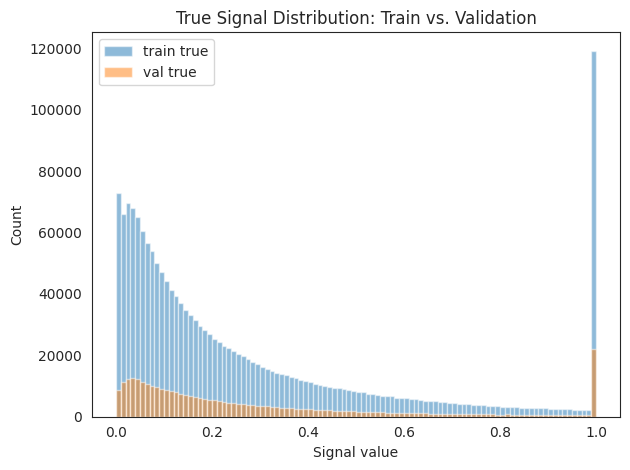

In [10]:
# Visualize the true‐signal distributions on train vs. validation
plt.hist(y_train, bins=100, alpha=0.5, label="train true")
plt.hist(y_val,   bins=100, alpha=0.5, label="val true")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Train vs. Validation")
plt.legend()
plt.tight_layout()
plt.show()


Training sees 3840 unique trading days per epoch.



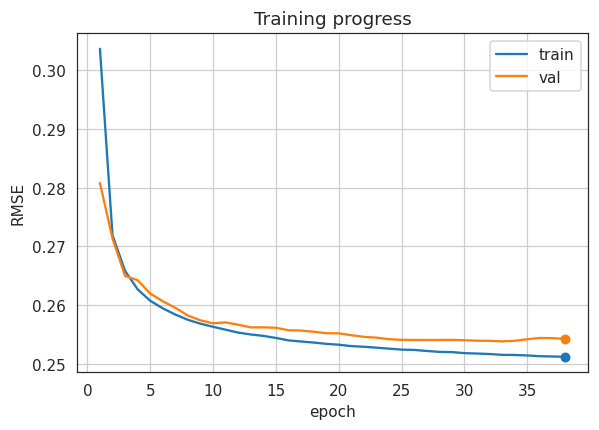

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.3037 MAE=0.2406 R2=-0.0950 | "B": Acc=0.4426 Prec=0.2902 Rec=0.7017 F1=0.4105 AUROC=0.5376
VALID→ "R": RMSE=0.2808 MAE=0.2154 R2=0.0428 | "B": Acc=0.6521 Prec=0.3679 Rec=0.2938 F1=0.3267 AUROC=0.5568


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2719 MAE=0.2081 R2=0.1222 | "B": Acc=0.4899 Prec=0.2962 Rec=0.6130 F1=0.3994 AUROC=0.5423
VALID→ "R": RMSE=0.2714 MAE=0.2128 R2=0.1061 | "B": Acc=0.6634 Prec=0.4073 Rec=0.3772 F1=0.3916 AUROC=0.5895


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2658 MAE=0.2010 R2=0.1609 | "B": Acc=0.4908 Prec=0.2990 Rec=0.6255 F1=0.4046 AUROC=0.5510
VALID→ "R": RMSE=0.2650 MAE=0.2033 R2=0.1477 | "B": Acc=0.6754 Prec=0.4240 Rec=0.3622 F1=0.3907 AUROC=0.6041


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2627 MAE=0.2000 R2=0.1807 | "B": Acc=0.4787 Prec=0.3009 Rec=0.6684 F1=0.4150 AUROC=0.5627
VALID→ "R": RMSE=0.2642 MAE=0.2028 R2=0.1524 | "B": Acc=0.6916 Prec=0.4512 Rec=0.3397 F1=0.3876 AUROC=0.6184


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2608 MAE=0.1991 R2=0.1927 | "B": Acc=0.4814 Prec=0.3059 Rec=0.6894 F1=0.4238 AUROC=0.5770
VALID→ "R": RMSE=0.2620 MAE=0.2010 R2=0.1669 | "B": Acc=0.7086 Prec=0.4869 Rec=0.2681 F1=0.3458 AUROC=0.6314


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2595 MAE=0.1980 R2=0.2007 | "B": Acc=0.4901 Prec=0.3114 Rec=0.6958 F1=0.4302 AUROC=0.5886
VALID→ "R": RMSE=0.2607 MAE=0.2009 R2=0.1752 | "B": Acc=0.7127 Prec=0.5000 Rec=0.2377 F1=0.3222 AUROC=0.6419


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2584 MAE=0.1973 R2=0.2072 | "B": Acc=0.4980 Prec=0.3156 Rec=0.6975 F1=0.4346 AUROC=0.5975
VALID→ "R": RMSE=0.2595 MAE=0.2002 R2=0.1823 | "B": Acc=0.7141 Prec=0.5055 Rec=0.2190 F1=0.3056 AUROC=0.6483


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2575 MAE=0.1966 R2=0.2127 | "B": Acc=0.5072 Prec=0.3203 Rec=0.6967 F1=0.4389 AUROC=0.6049
VALID→ "R": RMSE=0.2582 MAE=0.1989 R2=0.1905 | "B": Acc=0.7146 Prec=0.5084 Rec=0.1958 F1=0.2827 AUROC=0.6517


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2568 MAE=0.1960 R2=0.2168 | "B": Acc=0.5180 Prec=0.3252 Rec=0.6910 F1=0.4423 AUROC=0.6114
VALID→ "R": RMSE=0.2574 MAE=0.1978 R2=0.1957 | "B": Acc=0.7149 Prec=0.5104 Rec=0.1915 F1=0.2785 AUROC=0.6544


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2563 MAE=0.1951 R2=0.2200 | "B": Acc=0.5214 Prec=0.3273 Rec=0.6917 F1=0.4443 AUROC=0.6155
VALID→ "R": RMSE=0.2569 MAE=0.1978 R2=0.1989 | "B": Acc=0.7148 Prec=0.5096 Rec=0.1953 F1=0.2824 AUROC=0.6559


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2558 MAE=0.1945 R2=0.2230 | "B": Acc=0.5278 Prec=0.3307 Rec=0.6904 F1=0.4472 AUROC=0.6207
VALID→ "R": RMSE=0.2571 MAE=0.1987 R2=0.1979 | "B": Acc=0.7150 Prec=0.5108 Rec=0.1911 F1=0.2782 AUROC=0.6564


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2553 MAE=0.1941 R2=0.2260 | "B": Acc=0.5341 Prec=0.3336 Rec=0.6858 F1=0.4489 AUROC=0.6236
VALID→ "R": RMSE=0.2567 MAE=0.1983 R2=0.2003 | "B": Acc=0.7149 Prec=0.5107 Rec=0.1854 F1=0.2721 AUROC=0.6569


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2550 MAE=0.1937 R2=0.2279 | "B": Acc=0.5423 Prec=0.3370 Rec=0.6765 F1=0.4499 AUROC=0.6268
VALID→ "R": RMSE=0.2562 MAE=0.1978 R2=0.2031 | "B": Acc=0.7146 Prec=0.5090 Rec=0.1898 F1=0.2765 AUROC=0.6575


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2548 MAE=0.1933 R2=0.2294 | "B": Acc=0.5459 Prec=0.3392 Rec=0.6766 F1=0.4519 AUROC=0.6302
VALID→ "R": RMSE=0.2562 MAE=0.1983 R2=0.2031 | "B": Acc=0.7138 Prec=0.5051 Rec=0.1937 F1=0.2800 AUROC=0.6581


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2544 MAE=0.1931 R2=0.2315 | "B": Acc=0.5509 Prec=0.3417 Rec=0.6725 F1=0.4531 AUROC=0.6322
VALID→ "R": RMSE=0.2561 MAE=0.1985 R2=0.2036 | "B": Acc=0.7143 Prec=0.5075 Rec=0.1914 F1=0.2780 AUROC=0.6572


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2540 MAE=0.1929 R2=0.2340 | "B": Acc=0.5569 Prec=0.3448 Rec=0.6681 F1=0.4548 AUROC=0.6357
VALID→ "R": RMSE=0.2557 MAE=0.1978 R2=0.2062 | "B": Acc=0.7136 Prec=0.5040 Rec=0.1917 F1=0.2777 AUROC=0.6574


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2538 MAE=0.1925 R2=0.2352 | "B": Acc=0.5574 Prec=0.3454 Rec=0.6704 F1=0.4560 AUROC=0.6375
VALID→ "R": RMSE=0.2557 MAE=0.1981 R2=0.2065 | "B": Acc=0.7138 Prec=0.5050 Rec=0.1960 F1=0.2823 AUROC=0.6605


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2536 MAE=0.1924 R2=0.2362 | "B": Acc=0.5654 Prec=0.3494 Rec=0.6625 F1=0.4575 AUROC=0.6399
VALID→ "R": RMSE=0.2555 MAE=0.1980 R2=0.2077 | "B": Acc=0.7152 Prec=0.5120 Rec=0.1861 F1=0.2730 AUROC=0.6627


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2534 MAE=0.1921 R2=0.2376 | "B": Acc=0.5705 Prec=0.3516 Rec=0.6544 F1=0.4574 AUROC=0.6406
VALID→ "R": RMSE=0.2552 MAE=0.1979 R2=0.2093 | "B": Acc=0.7150 Prec=0.5107 Rec=0.1904 F1=0.2774 AUROC=0.6672


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2533 MAE=0.1921 R2=0.2385 | "B": Acc=0.5743 Prec=0.3540 Rec=0.6535 F1=0.4593 AUROC=0.6430
VALID→ "R": RMSE=0.2552 MAE=0.1979 R2=0.2094 | "B": Acc=0.7152 Prec=0.5115 Rec=0.1896 F1=0.2767 AUROC=0.6711


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2530 MAE=0.1918 R2=0.2399 | "B": Acc=0.5750 Prec=0.3548 Rec=0.6548 F1=0.4602 AUROC=0.6446
VALID→ "R": RMSE=0.2549 MAE=0.1974 R2=0.2114 | "B": Acc=0.7152 Prec=0.5113 Rec=0.1973 F1=0.2847 AUROC=0.6739


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2529 MAE=0.1917 R2=0.2405 | "B": Acc=0.5760 Prec=0.3562 Rec=0.6598 F1=0.4626 AUROC=0.6471
VALID→ "R": RMSE=0.2546 MAE=0.1972 R2=0.2132 | "B": Acc=0.7147 Prec=0.5086 Rec=0.2027 F1=0.2899 AUROC=0.6759


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2528 MAE=0.1917 R2=0.2415 | "B": Acc=0.5756 Prec=0.3560 Rec=0.6607 F1=0.4627 AUROC=0.6473
VALID→ "R": RMSE=0.2545 MAE=0.1970 R2=0.2140 | "B": Acc=0.7152 Prec=0.5112 Rec=0.2012 F1=0.2887 AUROC=0.6775


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2526 MAE=0.1915 R2=0.2425 | "B": Acc=0.5796 Prec=0.3586 Rec=0.6587 F1=0.4644 AUROC=0.6502
VALID→ "R": RMSE=0.2542 MAE=0.1967 R2=0.2156 | "B": Acc=0.7157 Prec=0.5134 Rec=0.2003 F1=0.2881 AUROC=0.6804


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2524 MAE=0.1914 R2=0.2435 | "B": Acc=0.5841 Prec=0.3613 Rec=0.6560 F1=0.4660 AUROC=0.6517
VALID→ "R": RMSE=0.2541 MAE=0.1967 R2=0.2163 | "B": Acc=0.7158 Prec=0.5135 Rec=0.2036 F1=0.2916 AUROC=0.6824


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2524 MAE=0.1914 R2=0.2438 | "B": Acc=0.5840 Prec=0.3609 Rec=0.6539 F1=0.4651 AUROC=0.6517
VALID→ "R": RMSE=0.2541 MAE=0.1969 R2=0.2164 | "B": Acc=0.7157 Prec=0.5132 Rec=0.2042 F1=0.2921 AUROC=0.6843


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2522 MAE=0.1912 R2=0.2449 | "B": Acc=0.5870 Prec=0.3629 Rec=0.6524 F1=0.4663 AUROC=0.6534
VALID→ "R": RMSE=0.2541 MAE=0.1971 R2=0.2164 | "B": Acc=0.7166 Prec=0.5170 Rec=0.2060 F1=0.2946 AUROC=0.6871


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2520 MAE=0.1911 R2=0.2458 | "B": Acc=0.5885 Prec=0.3642 Rec=0.6538 F1=0.4678 AUROC=0.6555
VALID→ "R": RMSE=0.2541 MAE=0.1976 R2=0.2165 | "B": Acc=0.7165 Prec=0.5164 Rec=0.2108 F1=0.2994 AUROC=0.6889


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2520 MAE=0.1911 R2=0.2460 | "B": Acc=0.5903 Prec=0.3654 Rec=0.6534 F1=0.4687 AUROC=0.6566
VALID→ "R": RMSE=0.2541 MAE=0.1977 R2=0.2164 | "B": Acc=0.7172 Prec=0.5189 Rec=0.2140 F1=0.3030 AUROC=0.6918


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2518 MAE=0.1911 R2=0.2471 | "B": Acc=0.5939 Prec=0.3680 Rec=0.6526 F1=0.4706 AUROC=0.6582
VALID→ "R": RMSE=0.2540 MAE=0.1978 R2=0.2167 | "B": Acc=0.7181 Prec=0.5233 Rec=0.2103 F1=0.3001 AUROC=0.6950


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2517 MAE=0.1910 R2=0.2475 | "B": Acc=0.5994 Prec=0.3713 Rec=0.6465 F1=0.4717 AUROC=0.6604
VALID→ "R": RMSE=0.2539 MAE=0.1977 R2=0.2172 | "B": Acc=0.7182 Prec=0.5233 Rec=0.2130 F1=0.3028 AUROC=0.6967


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2517 MAE=0.1911 R2=0.2480 | "B": Acc=0.5984 Prec=0.3709 Rec=0.6486 F1=0.4719 AUROC=0.6606
VALID→ "R": RMSE=0.2539 MAE=0.1978 R2=0.2174 | "B": Acc=0.7173 Prec=0.5186 Rec=0.2225 F1=0.3114 AUROC=0.6965


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2515 MAE=0.1910 R2=0.2488 | "B": Acc=0.5948 Prec=0.3695 Rec=0.6578 F1=0.4732 AUROC=0.6617
VALID→ "R": RMSE=0.2538 MAE=0.1979 R2=0.2179 | "B": Acc=0.7182 Prec=0.5221 Rec=0.2275 F1=0.3169 AUROC=0.6979


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2515 MAE=0.1909 R2=0.2489 | "B": Acc=0.5998 Prec=0.3725 Rec=0.6522 F1=0.4742 AUROC=0.6635
VALID→ "R": RMSE=0.2539 MAE=0.1983 R2=0.2173 | "B": Acc=0.7189 Prec=0.5246 Rec=0.2294 F1=0.3192 AUROC=0.7006


Epoch 35:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ "R": RMSE=0.2514 MAE=0.1910 R2=0.2495 | "B": Acc=0.6020 Prec=0.3737 Rec=0.6491 F1=0.4743 AUROC=0.6638
VALID→ "R": RMSE=0.2542 MAE=0.1990 R2=0.2157 | "B": Acc=0.7199 Prec=0.5283 Rec=0.2338 F1=0.3241 AUROC=0.7033


Epoch 36:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ "R": RMSE=0.2513 MAE=0.1909 R2=0.2502 | "B": Acc=0.6068 Prec=0.3769 Rec=0.6449 F1=0.4757 AUROC=0.6657
VALID→ "R": RMSE=0.2544 MAE=0.1996 R2=0.2143 | "B": Acc=0.7207 Prec=0.5317 Rec=0.2347 F1=0.3257 AUROC=0.7044


Epoch 37:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ "R": RMSE=0.2512 MAE=0.1908 R2=0.2505 | "B": Acc=0.6072 Prec=0.3770 Rec=0.6432 F1=0.4754 AUROC=0.6654
VALID→ "R": RMSE=0.2544 MAE=0.1995 R2=0.2145 | "B": Acc=0.7204 Prec=0.5306 Rec=0.2325 F1=0.3233 AUROC=0.7047


Epoch 38:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ "R": RMSE=0.2512 MAE=0.1908 R2=0.2508 | "B": Acc=0.6085 Prec=0.3781 Rec=0.6442 F1=0.4765 AUROC=0.6666
VALID→ "R": RMSE=0.2542 MAE=0.1994 R2=0.2153 | "B": Acc=0.7200 Prec=0.5286 Rec=0.2356 F1=0.3259 AUROC=0.7049


Epoch 39:   0%|          | 0/60 [00:00<?, ?batch/s]

KeyboardInterrupt: 

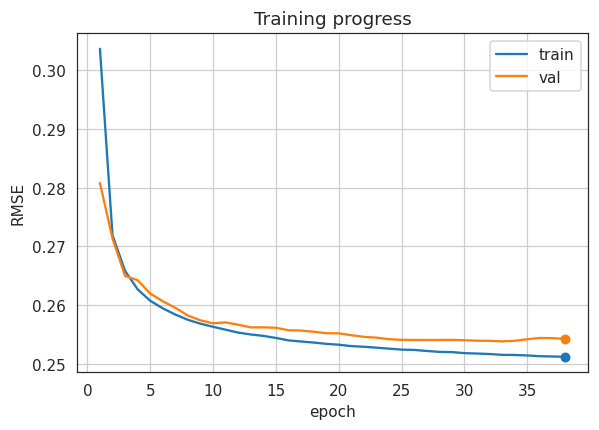

In [11]:
# How many unique trading days does each epoch see?
n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models.custom_stateful_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    clipnorm            = clipnorm,
    device              = params.device
)

# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement_zero = 100.0 * (1.0 - best_val_rmse / rmse_zero_val)
print(f"Improvement over zero‐baseline = {improvement_zero:5.1f}%")

improvement_mean = 100.0 * (1.0 - best_val_rmse / rmse_mean_val)
print(f"Improvement over mean‐baseline = {improvement_mean:5.1f}%")

